In [1]:
using IonimageSimulations
using Printf: @sprintf
using PyPlot

## Basics

*IonimageSimulations* package provides `simulateimg` function to simulate an photofragment ion image. Its typical signature is

```julia
    simulateimg(f::Function, n::Real;
                slice::Real=1.0, smin::Real=-slice, smax::Real=slice,
                size=(501, 501), center=@.((size+1)/2),
                rmin::Real=0, rmax::Real=(minimum(size)-1)/2)
```

where,

- `f`: photofragment distribution function; `f(p::Photofragment)::Float64`
- `n`: number of photofragments to simulate
- `rmin`(optional): the minimum limit of fragment speed (radius in pixel) taking into account in the simulation
- `rmax`(optional): the maximum limit of fragment speed (radius in pixel) taking into account in the simulation
- `slice`(optional): slicing width fraction to the diameter of Newton sphere, 1.0 for a totally projected image, 0.1 for an ideal (and typical) slice image
- `smin`,`smax`(optional): fine control of slicing range, it ranges from -1.0 to 1.0
- `size`(optional): size of screen `(height, width)` in pixcel, the default value is `(501, 501)`.
- `center`(optional): center coordinate of the projection `(y, x)`

---

The distribution function computes a population of particles with a certain recoiling velocity `v` and a direction `(Ω, Θ)`. More concretely, the distribution function `f` should take a `Photofragment` instance `p` as its argument, which has `p.v`, `p.Ω` and `p.Θ` as its speed and recoil direction. The definitions of $\Omega$ and $\Theta$ follow [Rakitzis et. al. 2003](https://linkinghub.elsevier.com/retrieve/pii/S0009261403003993). Then, `f` should return a scalar (`Float64`); that is, `f(p) isa Float64` should be true. Not necessarily to be normalized.

In principle, a distribution function can be expressed as a product of an angular distribution and a speed (energy) distribution. *IonimageSimulations* package exports several helper functions, `gauss` and `muckerman` for speed (energy) distributions, `zare` and `rakitzis` for angular distributions.

```
{Distribution function} = {Angular distribution function} × {Speed distribution function}
```


---

### Gauss

`gauss(x, μ, σ)` function returns a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) with the given parameters.

$$
gauss(x, \mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp{\frac{-(x - \mu)^2}{2\sigma^2}}
$$

---

### Muckerman

`muckerman(Et, Eavl, a, b)` Computes an energy distribution which follows the Muckerman's equation. [1]

$$
muckerman(E_t, E_{avl}, a, b) = (f_t)^a (1 - f_t)^b
$$

where, $f_t$ is the fraction of translational energy in total available energy, $f_t = E_t/E_{avl}$. `a` and `b` are adjustable parameters.

---

### Zare

`zare(Ω, Θ, ...)` returns a linear combination of [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) series for an angular distribution. [2] That is,

$$
zare(\Omega, \Theta, 2 => \beta_2, 4 => \beta_4, \cdots) = 1 + \beta_2 P_2(\cos\theta) + \beta_4 P_4(\cos\theta) \cdots
$$

where $P_n$ is the *n*-th order Legendre polynomials. The laser polarization is expected to be parallel with $X$ axis in the laboratory frame (Fig. 2); therefore, $\cos\theta = \sin\Omega \cos\Theta$. The optional arguments (...) should be pairs of an order of Legendre polynomials and a corresponding anisotropy parameter, `n => βₙ`.

---

### Rakitzis

`rakitzis()` function will be introduced in the later part of this notebook.

---

1. J. T. Muckerman, J. Phys. Chem. 93, (1989), 179–184.
1. Houston, Paul L. “Photochemistry.” In Chemical Kinetics and Reaction Dynamics, 204–56. New York: Dover Publications, 2006.

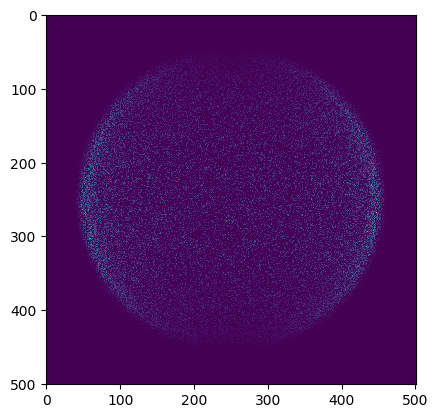

In [2]:
function distribution(p)
    Ispd = gauss(p.v, 200, 5)         # assuming that the speed distribution follows a Gaussian with μ = 200 and σ = 5 pixel
    Iang = zare(p.Ω, p.Θ, 2 => -1.0)  # assuming that the angular distribution is 1 + β₂P₂(cosθ) with β₂ = -1.0
    return Ispd*Iang
end

img = simulateimg(distribution, 1_000_000)
imshow(img)
;

## Use of do block

If a function `funcA` takes another function (for example, `funcB`) as the first parameter, there are several ways to write. Given that you have `funcA` which takes a function as the first argument.

```julia
function funcA(f, n)
    return f(n)
end
```

### Naive way

One of the way to use `funcA` is to define a parameter function `funcB`.

```julia
function funcB(n)
    return n + 1
end

funcA(funcB, 10)
```


### Anonymous function

Another way is to use *anonymous function*. This is handy if the function is simple enough; no need to write `function ~ end` block and also you don't need to name the parameter function.

```julia
funcA(n -> n + 1, 10)
```


### Do block

However, sometimes the parameter function gets long and/or complicated. In that case, *do block* syntax is the good way to go, which constructs a function in-place and give it to the first argument of the parent function (`funcA`); therefore, you can start writing from the second parameter of `funcA`.

```julia
funcA(10) do n
    return n + 1
end
```

The above three syntaxes do (almost) same work but each one has pros. and cons. in contexts. For `simulateimg`, the *do block* syntax is often useful to specify the distribution function.

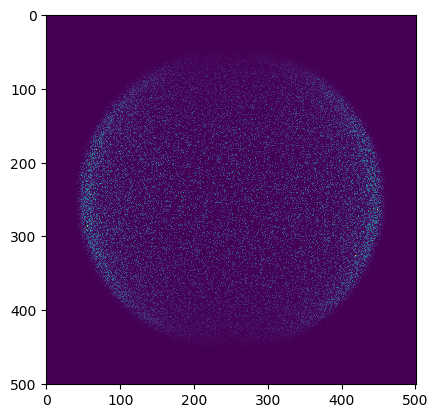

In [3]:
img = simulateimg(1_000_000) do p
    return gauss(p.v, 200, 5)*zare(p.Ω, p.Θ, 2 => -1.0)
end

imshow(img)
;

## Photofragment distribution of oriented molecules

If parent molecules are oriented, `rakitzis(Ω, Θ, ...)` is required to represent the angular distributions.

```julia
rakitzis(Ω, Θ; Γ=90.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=0.0, c2=0.0)
```

Those parameters comes from [Rakitzis et. al. 2003](https://linkinghub.elsevier.com/retrieve/pii/S0009261403003993). For more details, the orienting field vector $\vec{O}(\Delta, \Phi)$ points from the high voltage side to the low voltage side of the electric field. The permanent dipole moment $\vec{d}(\alpha)$ points from the negative to the positive charged distribution of the molecule. $c_1$ is positive when O and d vectors are directed toward the same way, and it is negative if not.

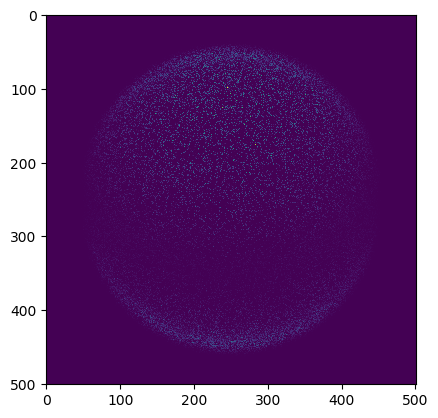

In [4]:
img = simulateimg(1_000_000) do p
    return gauss(p.v, 200, 5)*rakitzis(p.Ω, p.Θ; Γ=45.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=-0.5, c2=0.0)
end

imshow(img)
;

## Supplementary note on geometries

### Recoil frame
 - $\vec{v}$ : Recoil velocity vector
 - $\vec{d}$ : Permanent dipole moment
 - $\vec{\mu}$ : Transition dipole moment
 
$\alpha$ and $\chi$ are the angle of $\vec{d}$ and $\vec{\mu}$ to $\vec{v}$. $\varphi$ is the azimuthal angle between $\vec{d}$ and $\vec{\mu}$.

### Laboratory frame
 - $\vec{v}(\Omega, \Theta)$ : Recoil velocity
 - $\vec{\epsilon}(\Gamma)$ : Laser polarization

The orienting electric field $\vec{O}(\Delta, \Phi)$ also follows the same manner with $\vec{v}(\Omega, \Theta)$.

![Geometries](img/LabAndRecoilFrames.svg)

## Tips 1: Recoiling speed of fragments
`simulateimg()` function simulates particles with recoiling speed $0 \lt v \le max(height-1, width-1)/2$ if nothing specified. However, for example, with a Gaussian distribution the particles with recoiling speed $ \mu - \sigma \le v \le \mu + \sigma $ dominates its population actually. The simulations of the particles with $ v \lt \mu - \sigma, \mu + \sigma \lt v $ doesn't have significant contribution and would result in almost the waste of time. Specifying the proper velocity range may save your time.

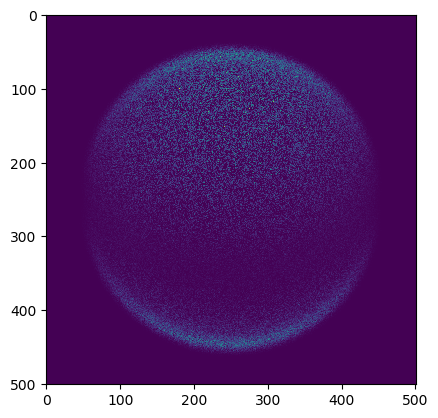

In [5]:
μ = 200
σ = 5
img = simulateimg(1_000_000, rmin=μ-5σ, rmax=μ+5σ) do p
    return gauss(p.v, 200, 5)*rakitzis(p.Ω, p.Θ; Γ=45.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=-0.5, c2=0.0)
end

imshow(img)
;

## Tips 2: Sliced imaging

`slice` keyword is convenient to simulate sliced ion images. It is the ratio of slicing thickness with respect to the whole Newton sphere. Typically, 1/10 of whole sphere is favolable to obtain a slice image.

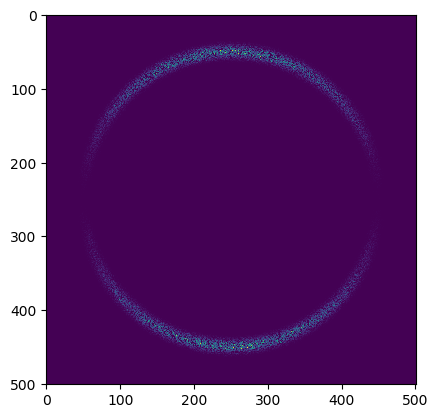

In [6]:
μ = 200
σ = 5
img = simulateimg(1_000_000, rmin=μ-5σ, rmax=μ+5σ, slice=0.1) do p
    return gauss(p.v, 200, 5)*rakitzis(p.Ω, p.Θ; Γ=45.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=-0.5, c2=0.0)
end

imshow(img)
;

If you want slices other than the center slice, use `smin` and `smax` key. It is the coordinate along the time-of-flight axis ranging from -1 to 1.

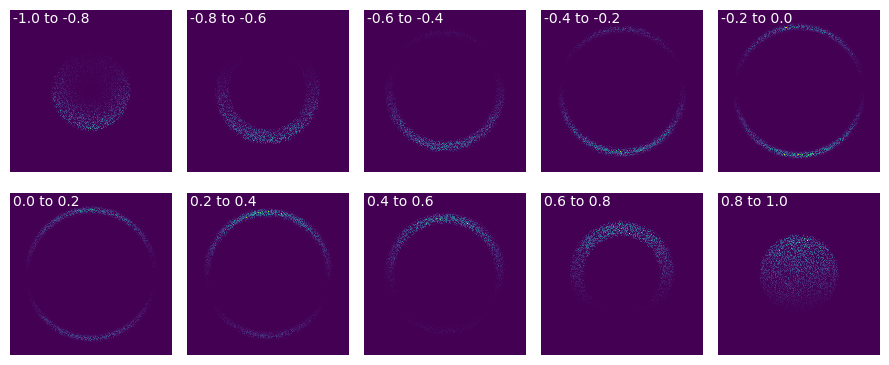

In [7]:
fig = figure(figsize=(9,4))

μ = 200
σ = 5
for i in 1:10
    smin = 0.2*(i - 1) - 1.0
    smax = 0.2*i - 1.0
    img = simulateimg(1_000_000, rmin=μ-5σ, rmax=μ+5σ, smin=smin, smax=smax) do p
        return gauss(p.v, 200, 5)*rakitzis(p.Ω, p.Θ; Γ=45.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=-0.5, c2=0.0)
    end

    ax = fig.add_subplot(2, 5, i)
    ax.imshow(img)
    ax.axis("off")
    smin_string = @sprintf("%.1f", smin)
    smax_string = @sprintf("%.1f", smax)
    ax.text(10, 40, "$(smin_string) to $(smax_string)", color="white")
end
fig.tight_layout()
;

## Tips 3: Image size

The image size (resolution) can be changed via `size` keyword, `size=(height, width)` in pixel. The default size is `(501, 501)`. You may need to change related parameters also, like velocity components, if you changed the resolution.

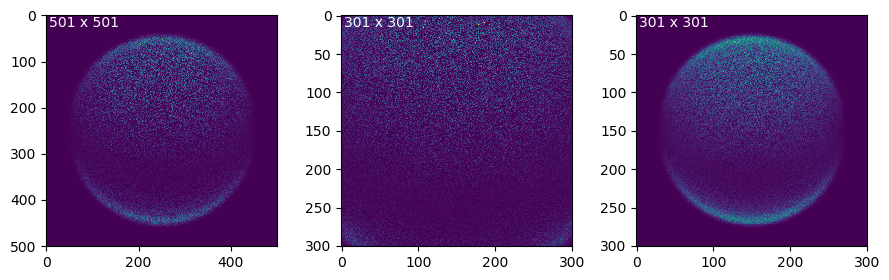

In [8]:
fig = figure(figsize=(9,3))

μ = 200
σ = 5

# Default size
img1 = simulateimg(1_000_000, rmin=μ-5σ, rmax=μ+5σ) do p
    return gauss(p.v, 200, 5)*rakitzis(p.Ω, p.Θ; Γ=45.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=-0.5, c2=0.0)
end
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img1)
ax.text(5, 25, "501 x 501", color="white")

# Change only the image size
img2 = simulateimg(1_000_000, rmin=μ-5σ, rmax=μ+5σ, size=(301, 301)) do p
    return gauss(p.v, 200, 5)*rakitzis(p.Ω, p.Θ; Γ=45.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=-0.5, c2=0.0)
end
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img2)
ax.text(3, 15, "301 x 301", color="white")

# Change the image size and velocity component so as to keep ion image inside the frame
img3 = simulateimg(1_000_000, rmin=(μ-5σ)*(3/5), rmax=(μ+5σ)*(3/5), size=(301, 301)) do p
    return gauss(p.v, 200*(3/5), 3)*rakitzis(p.Ω, p.Θ; Γ=45.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=-0.5, c2=0.0)
end
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img3)
ax.text(3, 15, "301 x 301", color="white")

fig.tight_layout()
;

## Tips 4: Shorthand of zare(p.Ω, p.Θ, ...)

In the above examples, the angle $\Omega$ and $\Theta$ is explicitly written for readability. However, it is not always easy to code like that. For `zare()` and `rakitzis()`, these functions can take a `Photofragment` directly as a parameter for convenience. That is, you can write `zare(p, ...)` instead of `zare(p.Ω, p.Θ, ...)`, `rakitzis(p; ...)` instead of `rakitzis(p.Ω, p.Θ; ...)`.

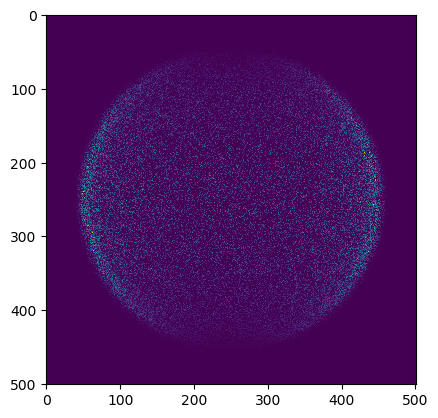

In [9]:
img = simulateimg(1_000_000) do p
    return gauss(p.v, 200, 5)*zare(p, 2 => -1.0)
end

imshow(img)
;

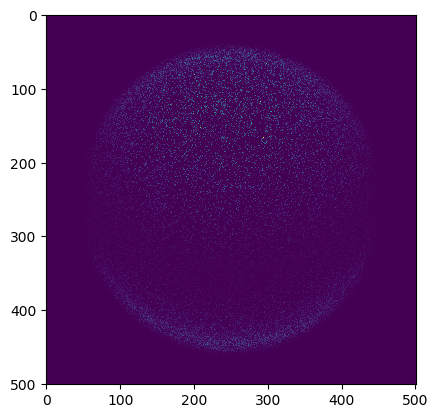

In [10]:
img = simulateimg(1_000_000) do p
    return gauss(p.v, 200, 5)*rakitzis(p; Γ=45.0, Δ=0.0, Φ=0.0, α=180.0, χ=0.0, ϕ=0.0, c1=-0.5, c2=0.0)
end

imshow(img)
;

# Tips 5: Shorthand for typical simulations

If you only use `gauss` for radial distribution and the second order term of `zare` for angular distribution, a handy interface is available. You can write just `simulateimg(n, μ, σ, β; ...)`, where `n` is the number of photofragments to simulate, `μ` and `σ` are for a `gauss` radial distribution, and `β` is the second order anisotropy parameter β₂ of `zare`.

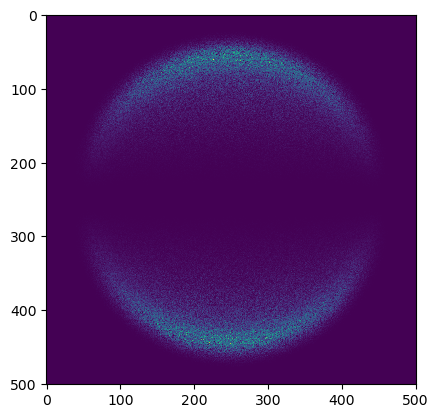

PyObject <matplotlib.image.AxesImage object at 0x0000000040052648>

In [24]:
img = simulateimg(1_000_000, 200, 10, 2.0)
imshow(img)

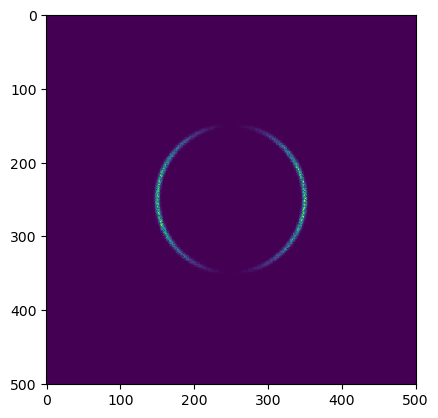

PyObject <matplotlib.image.AxesImage object at 0x000000003E665908>

In [25]:
img = simulateimg(1_000_000, 100, 2, -1.0; slice=0.1)
imshow(img)